In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def sample_normal_distribution(var):
    """
    Sample normal distribution with variance = var
    """
    rand = np.random.uniform(low=-1.0, high=1.0, size=12)
    return var * np.sum(rand) / 6

In [17]:
# CONSTANT
a = 10.

# feature-based map --> list of beacons coordinate
m = np.array([[0., 0., 0.],
              [a, 0., 0.],
              [a, a, a],
              [0., a, a]])  # each row defines 1 beacon
num_beacons = m.shape[0]

var_v = 1.  # m^2/s^2
var_z = 1.  # m^2

delta_t = 0.25  # s

In [18]:
def motion_model(x, u):
    """
    Compute motion model
    Input:
        x (np.ndarray) - shape 3,1 : robot location in 3D space
        u (np.ndarray) - shape 3,1 : motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape 3,1 : new robot location
    """
    return x + u * delta_t
    

In [19]:
def measurement_model(x, m):
    """
    Compute measurement model given state x (robot loc.) & map m
    Input:
        x (np.ndarray) - shape 3,1 : robot location in 3D space
        m (np.ndarray) - shape num_beacons,m : location of all beacons in the map
    Output:
        z (np.ndarray) - shape num_beacons, : distance from robot to each beacons
    """
    return np.sqrt(np.sum((m - x.squeeze())**2, axis=1))


In [21]:
def simulation_step(x, u):
    """
    Perform 1 step of simulation
    Input:
        x (np.ndarray) - shape (3,1) : robot location in 3D space
        u (np.ndarray) - shape (3,1): motion command (robot velocities)
    Output:
        xt (np.ndarray) - shape (3,1) : new robot location
        zt (np.ndarray) - shape (num_beacons,) : measurement at new location
    """
    # Perturb motion command
    u_noise = np.array([sample_normal_distribution(var_v) for i in range(3)])
    u_hat = u + u_noise
    
    # Compute new location
    xt = motion_model(x, u)  # here xt is the ground truth of robot location
    
    # Compute expected value of measurement
    zt_bar = measurement_model(xt, m) 
    # Perturb measurement
    zt = zt_bar + np.array([sample_normal_distribution(var_z) for i in range(num_beacons)])
    
    return xt, zt

In [22]:
def ekf(muy, sigma, u, z, m):
    """
    Implement an EKF to track robot location
    Input:
        muy (np.ndarray) - shape (3,1): expected robot location at previous time step (t-1)
        sigma (np.ndarray) - shape (3,3): covariance of robot location at previous time step (t-1)
        u (np.ndarray) - shape (3,1): motion command at this time step (t)
        z (np.ndarray) - shape (num_beacons,): measurement at this time step (t)
        m (np.ndarray) - shape (num_beacons,3): feature map contains location of all beacons
    Output:
        muy_t (np.ndarray) - shape (3,1): expected robot location at this time step (t)
        sigma_t (np.ndarray) - shape (3,3): covariance of robot location at this time step (t)
    """
    # predict location based on motion_model
    muy_bar =  motion_model(muy, u)
    # predict covariance
    sigma_bar = sigma + delta_t * np.diag([var_v, var_v, var_v])
    # measurement covariance
    Q = np.array([[var_z]])
    expected_meas = measurement_model(muy_bar, m)
    for i in range(num_beacons):
        # expected measurement
        z_hat = expected_meas[i]
        # jacobian of measurement model
        q = np.sum((m[i, :] - muy_bar)**2)
        x_bar, y_bar, z_bar = muy_bar.squeeze() 
        H = np.array([[x_bar - m[i, 0], y_bar - m[i, 1], z_bar - m[i, 2]]]) / np.sqrt(q)
        # kalman update
        S = H @ sigma_bar @ H.T + Q
        K = sigma_bar @ H.T / S.squeeze()
        muy_bar += K * (z[i] - z_hat)
        sigma_bar = (np.eye(3) - K @ H) @ sigma_bar
    
    return muy_bar, sigma_bar

In [23]:
# initialize
t = 0
muy = np.zeros((3,1))  # initial location
sigma = np.diag([0.1, 0.1, 0.1])  # initial covariance
u = np.array([[0.5, 0., 0.5]]).T  # keep constant for the whole trajectory

ground_truth = []
ekf_re = []
est_std_dev = []
time = []

# main loop
while t < 10.:
    # advance simulation 1 step 
    x_true, z = simulation_step(muy, u)
    
    # estimate new location
    muy_bar, sigma_bar = ekf(muy, sigma, u, z, m)
    
    # store ground truth & estimate
    ground_truth.append(x_true.reshape(1, -1))
    ekf_re.append(muy_bar.reshape(1, -1))
    est_std_dev.append(np.sqrt(np.diag(sigma_bar)))
    time.append(t)
    
    # update muy & sigma
    t += delta_t
    muy = muy_bar
    sigma = sigma_bar

In [24]:
ground_truth = np.vstack(ground_truth)
ekf_re = np.vstack(ekf_re)
est_std_dev = np.vstack(est_std_dev)

Text(0.5, 0.92, '3D Trajectory')

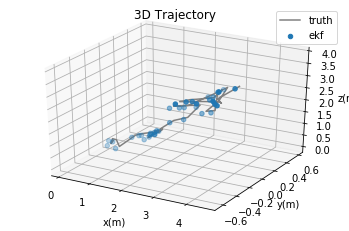

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], 'gray', label='truth')
ax.scatter3D(ekf_re[:, 0], ekf_re[:, 1], ekf_re[:, 2], cmap='Greens', label='ekf')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')
ax.legend()
ax.set_title('3D Trajectory')

Text(0.5, 1.0, 'Trajectory projected onto XZ-plane')

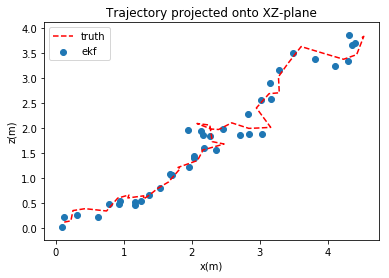

In [26]:
plt.plot(ground_truth[:, 0], ground_truth[:, 2], 'r--', label='truth')
plt.scatter(ekf_re[:, 0], ekf_re[:, 2], label='ekf')
plt.legend()
plt.xlabel('x(m)')
plt.ylabel('z(m)')
plt.title('Trajectory projected onto XZ-plane')

Text(0.5, 1.0, 'Estimated Standard Deviation')

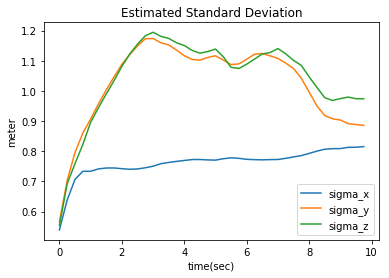

In [29]:
plt.plot(time, est_std_dev[:, 0], label='sigma_x')
plt.plot(time, est_std_dev[:, 1], label='sigma_y')
plt.plot(time, est_std_dev[:, 2], label='sigma_z')
plt.legend()
plt.xlabel('time(sec)')
plt.ylabel('meter')
plt.title('Estimated Standard Deviation')